## Task 5/5 : Learning Crowd Dynamics

In this task, a dynamical system was learnt that predicts the utilization of the MI building in Garching.

The dataset MI timesteps.txt contains utilization data for several measurement areas on the campus, over the
course of seven weekdays. 

Students enter the area from the U-Bahn in the morning, move to the MI-building, walk to one of the two mensas (student and Max Planck) during lunch, go back to studying and then move back to the U-Bahn in the evening. 

A burn-in period of 1000 time steps at the beginning of the file has been ignored.

In [40]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Creating a Delay Embedding
Here we read the MI_timesteps.txt file to prepare a delay embedding of 1053 dimensional vectors.

All these vectors are stored in vec_list array and converted to a numpy array X which serves as our main data array for PCA.

Number of data points M = 13651.

In [41]:
from utility import *

embed_array, full_embed_array = read_file("MI_timesteps.txt")

# Create a Delay Embedding by taking a window of 351 rows starting at every row
# and reshaping it into a 3X351 = 1053 dimensional vector
vec_list = []
for i in range(len(embed_array)-351):
    vec_list.append(embed_array[i:351+i].reshape(-1))
    
X = np.array(vec_list)
print(X.shape)

(13651, 1053)


### Singular Value Decomposition
Here we do an SVD on delay embedding dataset X.

In [42]:
U, S, Vh = np.linalg.svd(X - np.mean(X, axis=0))

### Principal Component Analysis
Since our data recorded is periodic and has no parametric dependence, it is a closed one-dimensional loop. 

According to Taken's theorem, to embed the points efficiently in the PCA space we need to reduce the feature space to atleast one more than 2d dimensions, where d is the actual number of dimensions of the observed data. Hence r = 2*d+1=3

The pca matrix of X can be constructed taking the first r columns of $U$ and first r diagonal entries of $S$ obtained from SVD done on X.

$X_{pca} = U_{r} S_{r}$

In [43]:
d = 1 #since the data is a one dimensional closed loop d=1
k = 2*d + 1 #according to taken's theorem

# Computing the PCA components of data X
x_pca = U[:,:k]@np.diag(S[:k]) 

### Plotting the PCA representations of the system

The points by all measurements taken at the first time point of the delays, for all nine measurement areas have been colored and plotted accordingly.

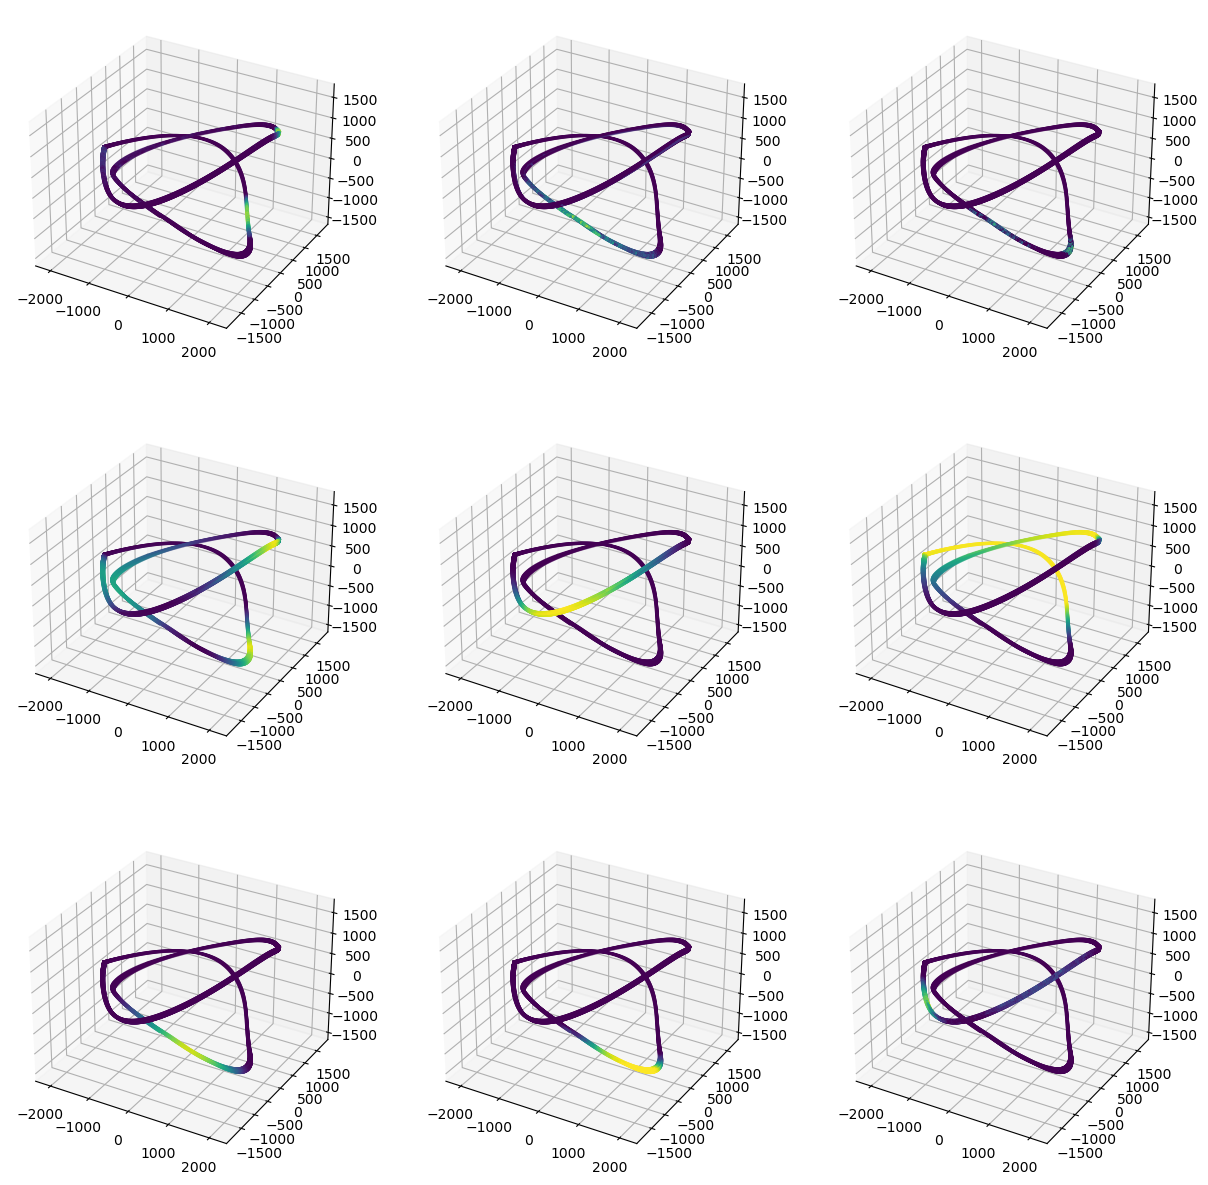

In [44]:

fig = plt.figure(figsize=(15,15))
for i in range(3):
    for j in range(3):
        ax = fig.add_subplot(3, 3, i*3 + j + 1, projection='3d')
        ax.scatter(*x_pca.T,s=1, c=full_embed_array[:len(x_pca), (i-1)*3+(j-1)])
plt.show()

where the total arc length of the curves comes out to be ...

In [45]:
arc_len = 0
cum_arc_len_array = []
for i in range(1,len(x_pca)):
    arc_len += np.linalg.norm(x_pca[i]-x_pca[i-1])
    cum_arc_len_array.append(arc_len)

print(f"Arc Length: {arc_len}")

Arc Length: 149460.68722904922


### Computing Arc Length Velocity in the PCA space

Here we determine how fast the system advances over the PCA space at every point in the space. 
We know which point is the predecessor of which other point, since all of them come from a single time series of measurements. 

We can compute the arclength of the curve in the PCA space and then approximate the change of arclength over time: a vector field on the
arclength.

Text(0.5, 1.0, 'Variation of Arc Length Velocity over entire Curve')

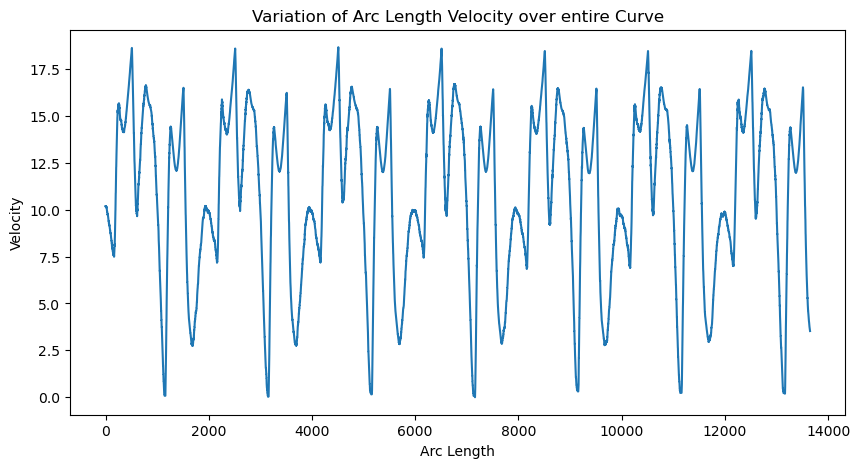

In [46]:
#print(cum_arc_len_array)
arc_len_vel = []
for i in range(1,len(cum_arc_len_array)):
    vel = cum_arc_len_array[i] - cum_arc_len_array[i-1]
    arc_len_vel.append(cum_arc_len_array[i]-cum_arc_len_array[i-1])


fig = plt.figure(figsize=(10,5))
plt.xlabel('Arc Length')
plt.ylabel('Velocity')
plt.plot(arc_len_vel)
plt.title("Variation of Arc Length Velocity over entire Curve")

As we can see the arc length change velocity is periodic. This means we can also find the period of the PCA curve.

Period after which arc length variation repeats: 2001


Text(0.5, 1.0, 'Variation of Arc Length Velocity over period')

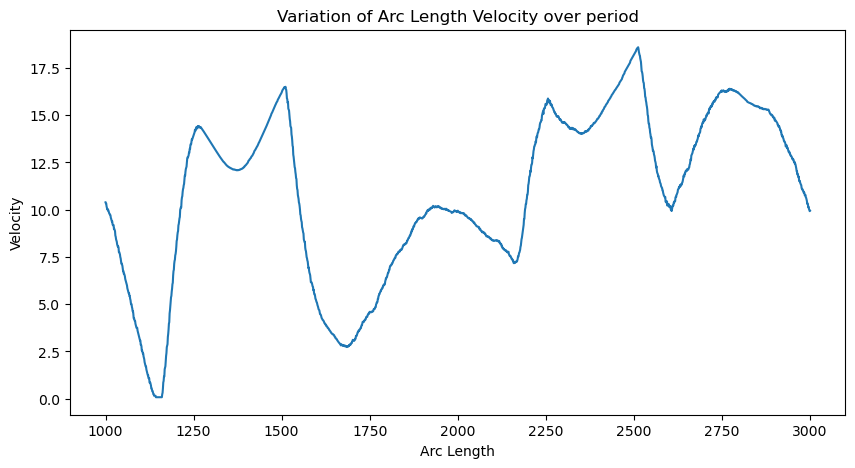

In [47]:
period = 0

max_vel = 0
max_loc = 0
for i, vel in enumerate(arc_len_vel):
    if vel>max_vel:
        max_vel = vel
        max_loc = i
        #print(f"max_vel:{max_vel}, max_loc:{max_loc}")
    if(i-max_loc>1000):
        if np.abs(vel-max_vel) < 5e-2:
            period = i-max_loc
            break

print(f"Period after which arc length variation repeats: {period}")

fig = plt.figure(figsize=(10,5))
plt.xlabel('Arc Length')
plt.ylabel('Velocity')
plt.plot(range(1000,1000+period),arc_len_vel[1000:1000+period])
plt.title("Variation of Arc Length Velocity over period")

Integrating the arc length velocity over the periodic space we get the below periodic curve for change in PCA arc length

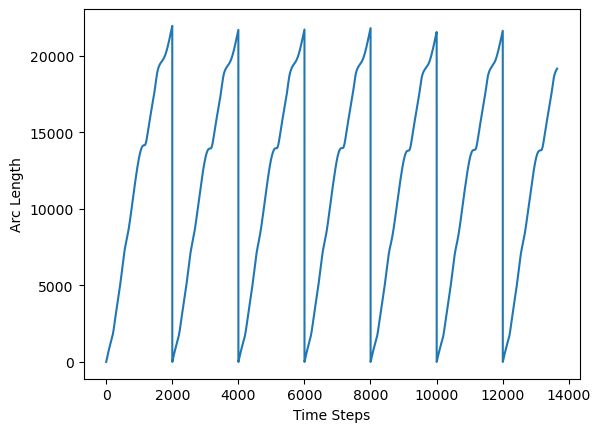

In [48]:
arc_len1 = 0
cum_arc_len_array1 = []
for i in range(len(x_pca)):
    if i%period==0:
        arc_len1 = 0
    else: arc_len1 += np.linalg.norm(x_pca[i] - x_pca[i-1])
    cum_arc_len_array1.append(arc_len1)
plt.xlabel('Time Steps')
plt.ylabel('Arc Length')
plt.plot(cum_arc_len_array1)

### Approximating Non Linear Functions using Radial Basis Functions
Since the utilization space is a non linear function over arc length, we will use radial basis functions to generate a mapping from arc length to utilization space 

$\Phi(X) C = F_{utilization}$

where $X \in R^{N X n}$ is the data array for arc length at every time step, and $F_{utilization} \in R^{N X d}$ and $N$ is the number of time steps.

Radial Basis Function matrix $\Phi(X) \in R^{N X L}$ equals 

$\Phi(X) = \exp(-||X - x_{l}||_{2}^{2}/\epsilon^{2})$

with coefficient matrix $C \in R^{L  X  d}$

where $L$ is the number of basis functions used and $x_{l}$ is the array containing the centers of the $L$ basis functions chosen. Here $n$ and $d$ are both equal to 1.

Similar to diffusion maps but with a slight change we computed $\epsilon$ as 

$\epsilon = 0.05 max(X - x_{l})$

In [49]:
import numpy as np
L = 200

X = np.array(cum_arc_len_array1) 
F = full_embed_array[:len(X),0]

xl = np.linspace(np.min(X), np.max(X), L)

X = np.expand_dims(X, axis=1).repeat(len(xl), axis=1)
xl = np.expand_dims(xl, axis=0).repeat(len(X), axis=0)

epsilon_upper = 0.05*np.max(X - xl)
print(epsilon_upper)

phi_X = np.exp(-((X - xl)/epsilon_upper)**2)
#print(C)
#plt.plot(phi_X)

1096.7012650590784


computing coefficient matrix C through least squares optimization

$C = (\Phi(X)^{T}\Phi(X))^{-1}\Phi(X)^{T}F$

In [50]:
#C = np.linalg.pinv(phi_X.T@phi_X)@phi_X.T@F
C = np.linalg.lstsq(phi_X, F, rcond=None)[0]

## Choice of parameters L and $\epsilon$
A range of L and $\epsilon$ values (10 to 500 in steps of 2 for L and 20 values between 0.1 to 110 for $\epsilon$ (upper limit taken to that of diffusion maps)  were iterated to achieve the MSE with little improvement. As we increase value of L, MSE always improves but reaches a stage where the improvement is minimal.

In [51]:
L, epsilon, xl, C, phi_X = compute_best_rbf_params(range(10,500,2), np.linspace(0.1, epsilon_upper, 20), cum_arc_len_array1, full_embed_array[:len(X),0], verbose=True) 

Current config L:10, Best Current MSE: 466.601253, Best MSE : 466.601253, best_L: 10, best_eps:1096.7012650590784
Current config L:12, Best Current MSE: 140.483720, Best MSE : 140.483720, best_L: 12, best_eps:1096.7012650590784
Current config L:14, Best Current MSE: 46.799034, Best MSE : 46.799034, best_L: 14, best_eps:1096.7012650590784
Current config L:16, Best Current MSE: 21.731378, Best MSE : 21.731378, best_L: 16, best_eps:1096.7012650590784
Current config L:18, Best Current MSE: 17.217644, Best MSE : 17.217644, best_L: 18, best_eps:1096.7012650590784
Current config L:20, Best Current MSE: 17.349115, Best MSE : 17.217644, best_L: 18, best_eps:1096.7012650590784
Current config L:22, Best Current MSE: 17.049571, Best MSE : 17.049571, best_L: 22, best_eps:1096.7012650590784
Current config L:24, Best Current MSE: 16.249189, Best MSE : 16.249189, best_L: 24, best_eps:1096.7012650590784


### Plotting $F_{utilization}$

Here we have ignored the first 1000 time steps of burn in time ...

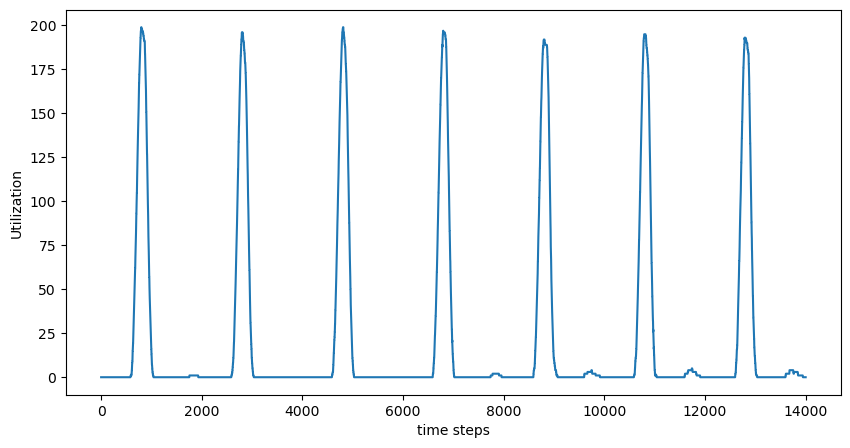

In [52]:
fig = plt.figure(figsize=(10,5))
plt.xlabel('time steps')
plt.ylabel('Utilization')
plt.plot(full_embed_array[:,0])

checking whether our $C$ was learnt well, by computing solution using the radial basis of functions

(26,)


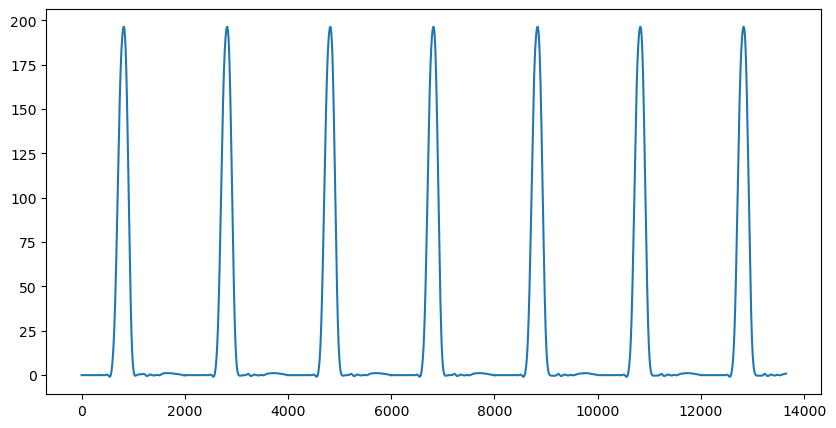

In [53]:
print((C).shape)
fig = plt.figure(figsize=(10,5))
plt.plot(phi_X@C)

we obtain a really good reconstruction of the utilization space!

### Predicting Utilization for the next 14 days using the learnt C matrix

For this we need to integrate our arc length velocity for 3 (3.1 since we ignored the burn in time) times the number of time steps to obtain the arc length array for the extended period of time.

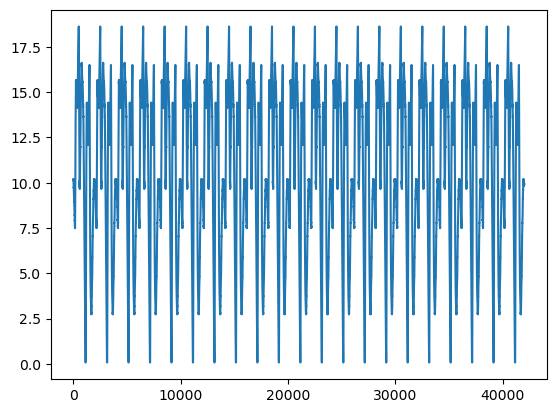

In [54]:
# Velocity over a period
arc_len_vel_long = []
for i in range( int(3.1 * len(full_embed_array)/period)):
    arc_len_vel_long += arc_len_vel[:period]

#arc_len_long = np.tile(arc_len_vel, 3)
plt.plot(arc_len_vel_long)

In [55]:
# Integrating the arc length velocity over the periodic domain
arc_len_long = []
arc_length = 0
for i in range(len(arc_len_vel_long)):
    if i%period==0: arc_length = 0
    else:
        arc_length += arc_len_vel_long[i]
    arc_len_long.append(arc_length)

# Constructing New phi_X for the extended arc length space
X = np.array(arc_len_long)
X_ = np.expand_dims(X, axis=1).repeat(L, axis=1)

xl_ = np.expand_dims(xl[0,:], axis=0).repeat(len(X), axis=0)
phi_X_ = np.exp(-((X_ - xl_)/epsilon)**2)
print(phi_X_.shape)

(42021, 26)


Using the same C matrix for our RBFs $\Phi(X)$, we plot our predicted utilization in red, and given utilization in blue

$F_{predicted} = \Phi(X)C$

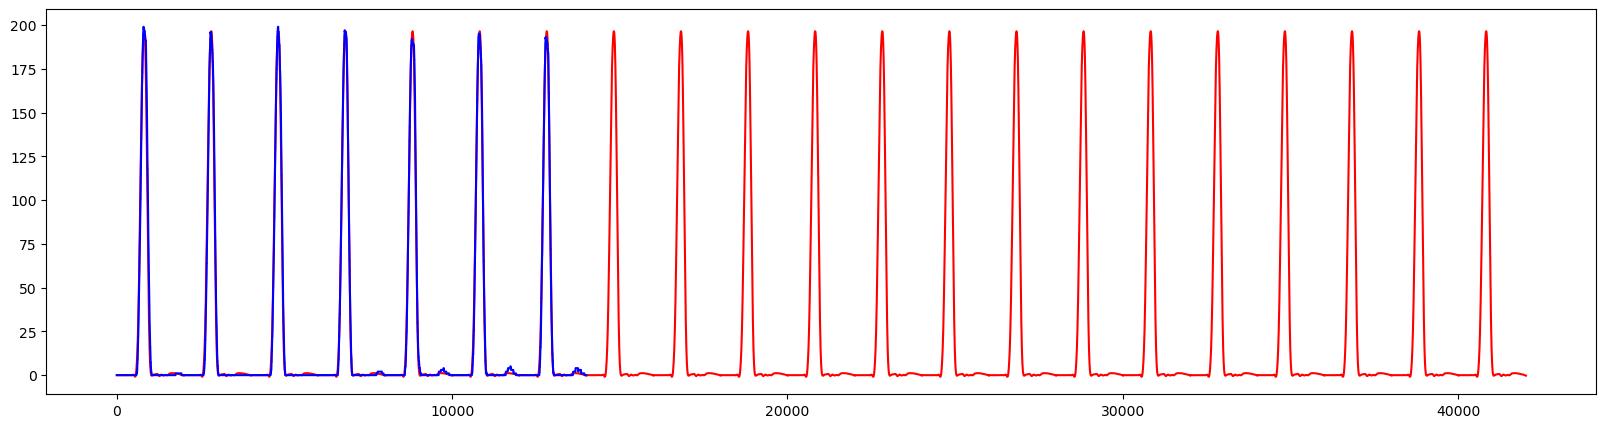

In [56]:
fig = plt.figure(figsize=(20,5))
y = phi_X_@C
plt.plot(range(len(y)), y[:], 'r')
plt.plot(full_embed_array[:,0], 'b')

The predictions seem accurate due to their complete overlap with given utilization value! Since the given utilization values were for a period of 7 days, our curve in red is thrice as long (twice after the blue one gets over)!